In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 12)


import geopandas as gpd
import pandas as pd
import rasterio as rio

from rasterio import plot as rio_plot

In [2]:
boundaries = gpd.read_file(str(Path('../data/external/gadm28_levels.shp/gadm28_adm2.shp')))

In [3]:
admin_2_uga = boundaries[boundaries.ISO == 'UGA']
admin_2_rwa = boundaries[boundaries.ISO == 'RWA']

In [5]:
def clean_uga_districts(series):
    ss = (series.str.strip()
                    .str.lower()
                    .replace({'ssembabule': 'sembabule'}))
    
    return ss

admin_2_uga.NAME_2 = clean_uga_districts(admin_2_uga.NAME_2)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [6]:
def clean_rwa_districts(series):
    ss = (series.str.strip()
                    .str.lower()
                    .str.strip(" district"))
    
    return ss

admin_2_rwa.NAME_2 = clean_rwa_districts(admin_2_rwa.NAME_2)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
who_df = pd.read_csv(Path("../data/interim/calc_cols_added.csv"), index_col=0)

who_uga = who_df[who_df['Iso Code'] == 'UGA']
who_rwa = who_df[who_df['Iso Code'] == 'RWA']

who_uga.Admin2 = clean_uga_districts(who_uga.Admin2)
who_rwa.Admin2 = clean_rwa_districts(who_rwa.Admin2)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [10]:
def get_dropout(dd):
    dtp_dropout = dd[dd['Vaccine Type'].isin(['DTP1', 'DTP3'])]

    dropout = (dtp_dropout.groupby(['Admin2', 'Vaccine Type'])
                                    .agg({
                                        'recalc_numerator': 'first',
                                        'Denominator': 'first'
                                    })
                                    .assign(coverage=lambda x: x.recalc_numerator / x.Denominator)
                                    .coverage
                                    .unstack(-1)
                                    .pipe(lambda x: 100 * (x.DTP1 - x.DTP3) / x.DTP1))

    dropout.name = 'dtp_dropout'
    return dropout
    
    
dropout_uga = get_dropout(who_uga)
dropout_rwa = get_dropout(who_rwa)

In [18]:
dropout_uga.describe()

count    112.000000
mean       5.815907
std        6.890528
min      -19.509412
25%        1.712658
50%        6.341486
75%        9.781542
max       23.635135
Name: dtp_dropout, dtype: float64

In [ ]:
gs1 = gridspec.GridSpec(1, 3)

ax1 = plt.subplot(gs1[:, :-1])
ax2 = plt.subplot(gs1[:, 1])

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


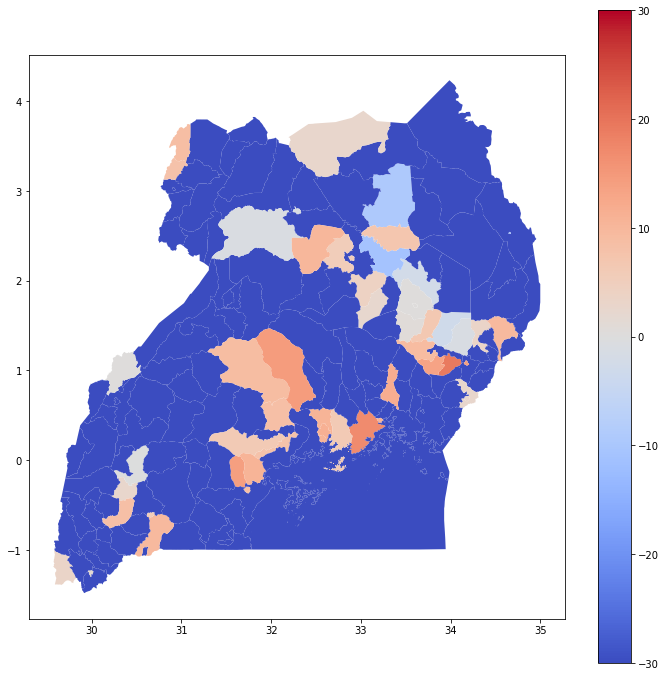

In [58]:
def plot_map(data, admin, col=None, colorbar=True, bidi=False,
             vmin=None, vmax=None):
    if isinstance(data, pd.Series):
        col = data.name
    
    kwargs = dict(
        column=col,
        cmap=plt.cm.coolwarm if bidi else plt.cm.magma
    )
    
    if colorbar:
        kwargs.update(dict(
           legend=True,
           vmin=vmin if vmin is not None else data.min(),
           vmax=vmax if vmax is not None else data.max(),
        ))
        
    figsize(12, 12)
    
    ax = (admin.set_index('NAME_2')
               .join(data)
               .plot(**kwargs))
     
plot_map(dropout_uga, admin_2_uga, colorbar=True, bidi=True,
         vmin=-30, vmax=30)

Mean:  5.815907474667061


(-30, 30)

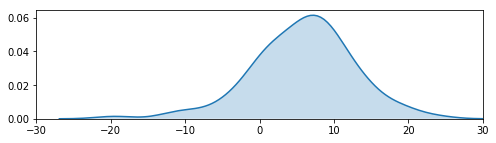

In [86]:
plt.subplots(figsize=(8, 2))
g = sns.kdeplot(dropout_uga,
            shade=True,
            legend=False)

print("Mean: ", dropout_uga.mean())
g.set_xlim((-30, 30))

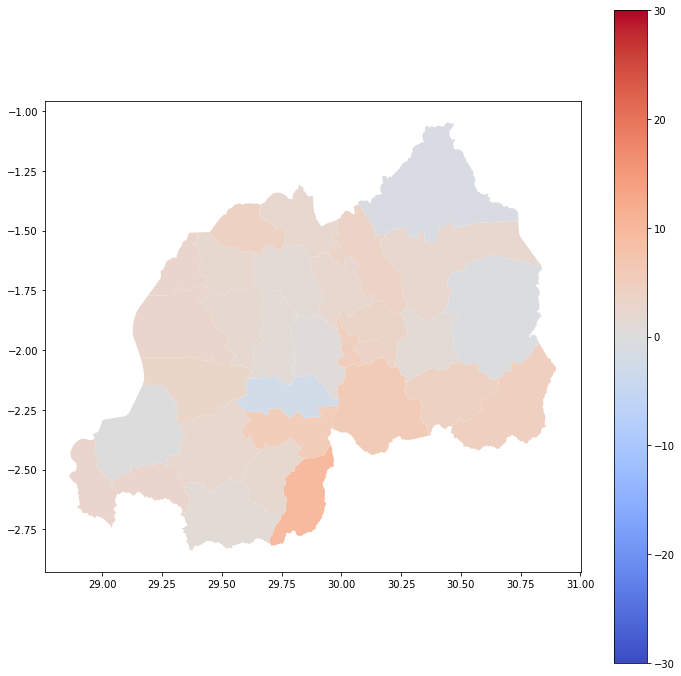

In [60]:
plot_map(dropout_rwa, admin_2_rwa, colorbar=True, bidi=True,
         vmin=-30, vmax=30)

Mean:  2.6703557362148844


(-30, 30)

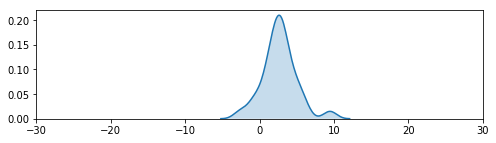

In [85]:
plt.subplots(figsize=(8, 2))
g = sns.kdeplot(dropout_rwa,
            shade=True,
            legend=False)


print("Mean: ", dropout_rwa.mean())
g.set_xlim((-30, 30))

BCG min 80.68169743831541
BCG max 138.42339803231002
BCG mean 104.49241901263761


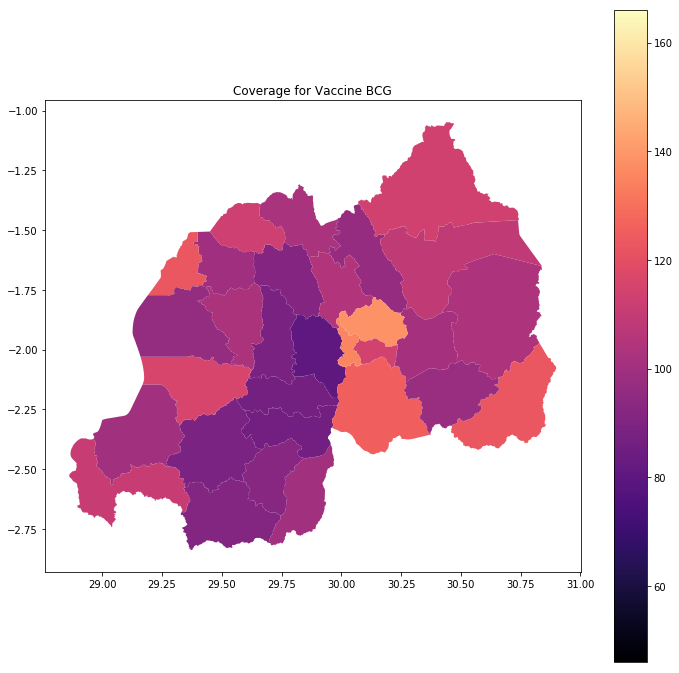

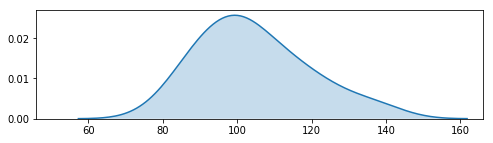

DTP3 min 83.258849362521
DTP3 max 133.817032802376
DTP3 mean 101.64487487750704


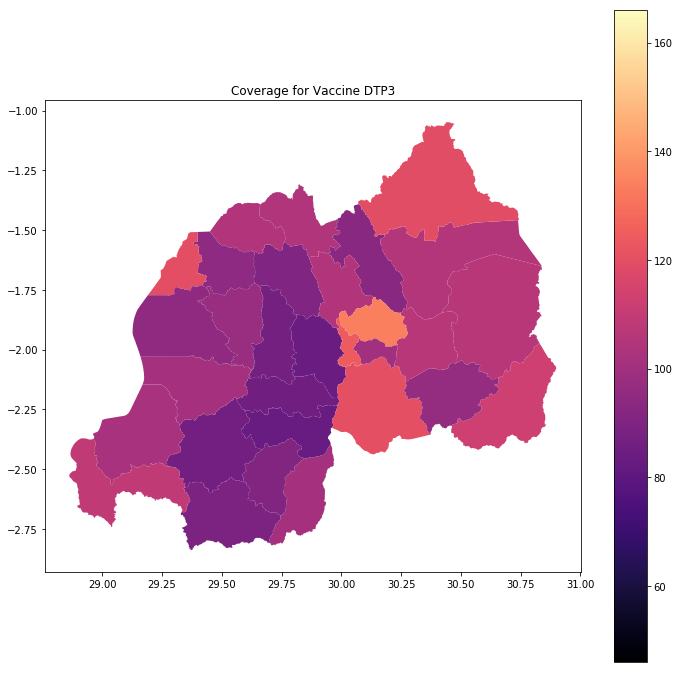

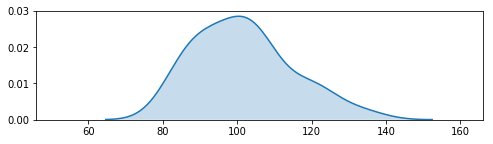

MCV1 min 81.41600309399759
MCV1 max 123.417643326326
MCV1 mean 98.63506408396513


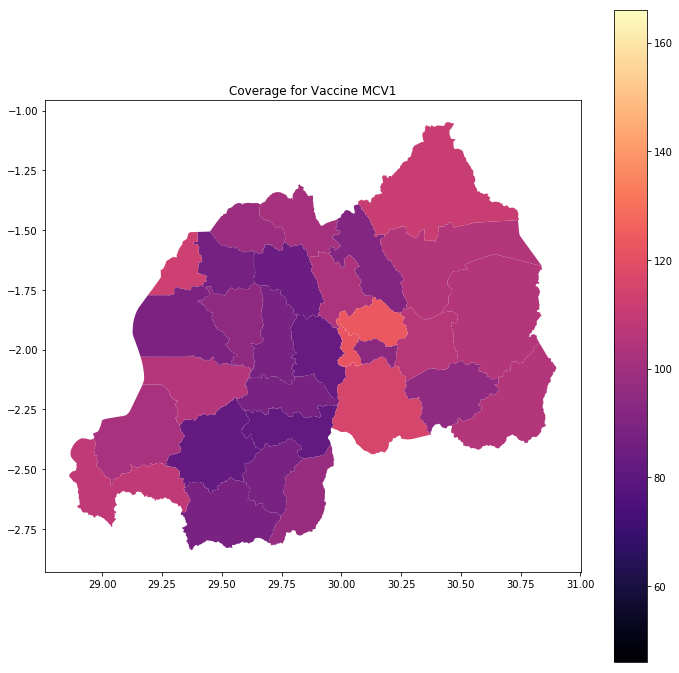

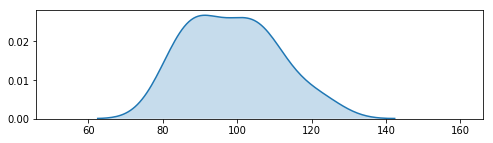

In [90]:
def plot_3(dd, admin, vaxes=['BCG', 'DTP3', 'MCV1'], kde=False):
    
#     fig, ax = plt.
    
    for vt in vaxes:
        c_data = (dd[dd['Vaccine Type'].str.startswith(vt)]
                         .set_index('Admin2')
                         .Coverage)
        
        print(vt, "min", c_data.min())
        print(vt, "max", c_data.max())
        print(vt, "mean", c_data.mean())
       
    
        plot_map(c_data,
                 admin,
                 vmin=46, vmax=166)
        
        plt.title(f"Coverage for Vaccine {vt}")
        plt.show()
        
        if kde:
            
            plt.subplots(figsize=(8, 2))
            g = sns.kdeplot(c_data,
                        shade=True,
                        legend=False)

            g.set_xlim((46, 166))
            plt.show()

plot_3(who_rwa, admin_2_rwa, kde=True)

BCG min 46.21053404633229
BCG max 147.829653504708
BCG mean 91.65532967332688


/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


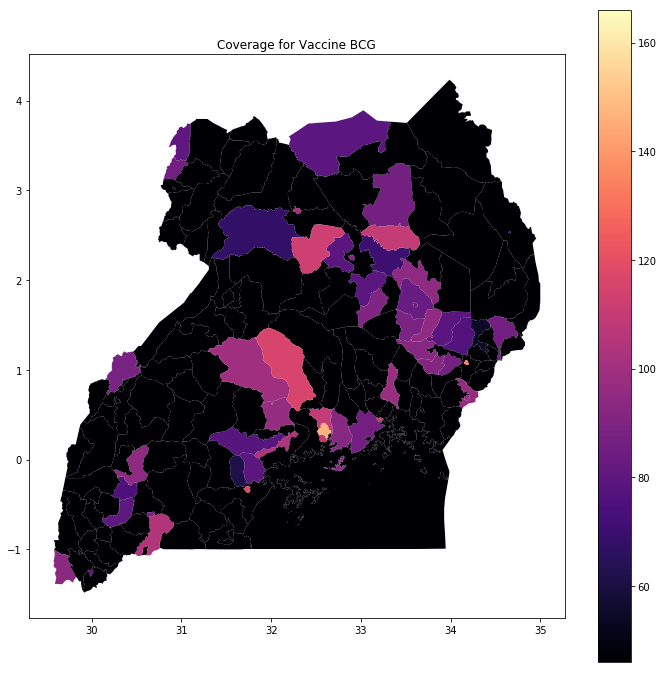

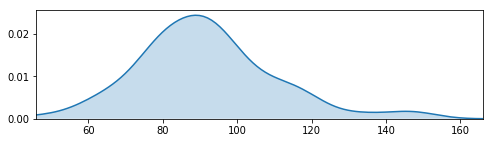

DTP3 min 63.7209073025162
DTP3 max 171.481552340252
DTP3 mean 101.5877477754995


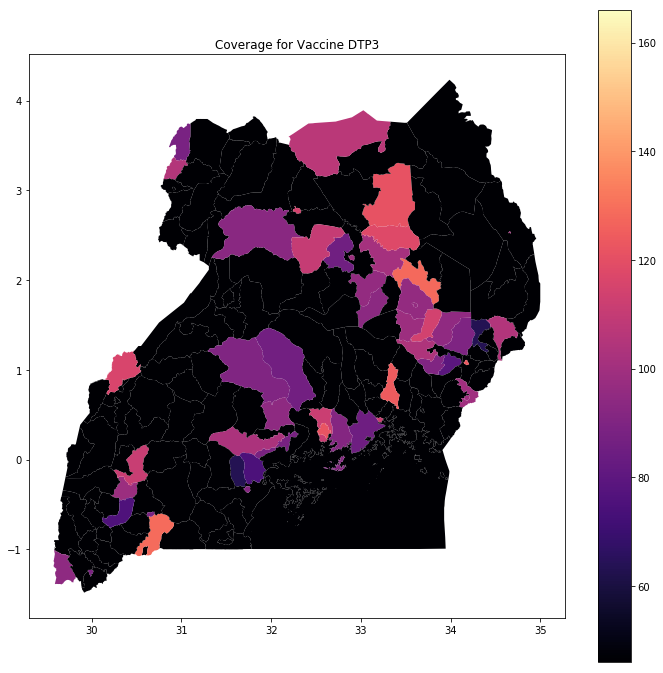

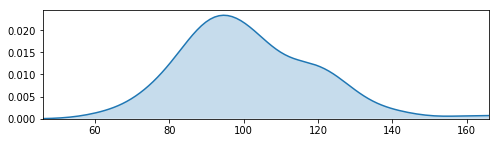

MCV1 min 53.4198033092847
MCV1 max 166.91424707211002
MCV1 mean 90.09075179794024


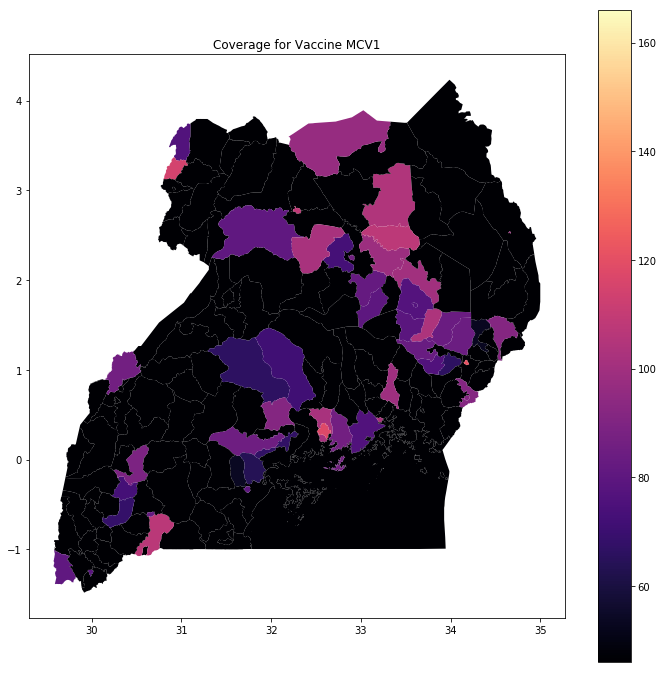

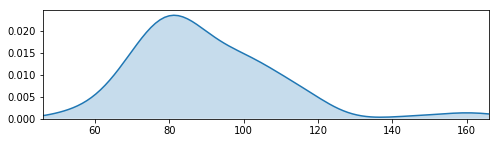

In [91]:
plot_3(who_uga, admin_2_uga, kde=True)